In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split
import os
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model

Using TensorFlow backend.


# Examples of infected cells

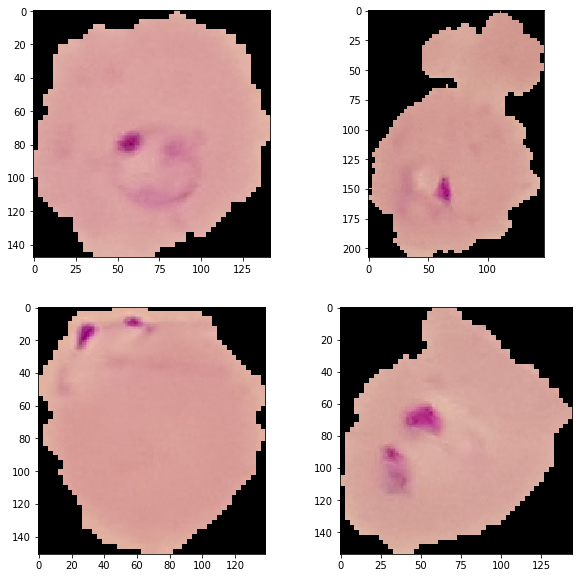

In [2]:
DATA_DIR = "C:\\Users\\sohai\\Desktop\\Thinkful Data Science\\Specializations\\Tensorflow\\cell_images"
CATEGORIES = ['Uninfected', 'Infected']
n_row = 2
n_col = 2
fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(10,10))

path = os.path.join(DATA_DIR, CATEGORIES[1])
for img in enumerate(os.listdir(path)):
    if img[0]==4:
        break
    else:
        img_array = plt.imread(os.path.join(path, img[1]))
        ax=axes[img[0]//n_row,img[0]%n_col]
        ax.imshow(img_array)

# Examples of uninfected cells

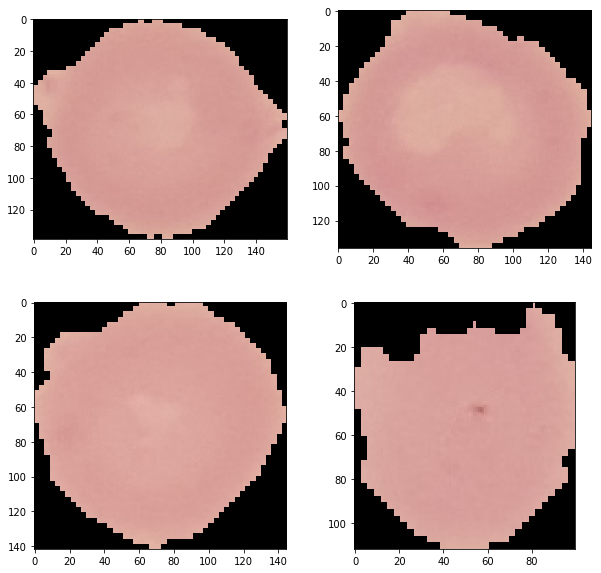

In [3]:
n_row = 2
n_col = 2
fig, axes = plt.subplots(nrows=n_row, ncols=n_col, figsize=(10,10))

path = os.path.join(DATA_DIR, CATEGORIES[0])
for img in enumerate(os.listdir(path)):
    if img[0]==4:
        break
    else:
        img_array = plt.imread(os.path.join(path, img[1]))
        ax=axes[img[0]//n_row,img[0]%n_col]
        ax.imshow(img_array)

In [9]:
IMG_SIZE=50
dataset = []
def create_training_data():
    for cat in CATEGORIES:
        path = os.path.join(DATA_DIR, cat)
        class_num = CATEGORIES.index(cat)
        for img in os.listdir(path):
            try:
                #read data in grayscale in order to save time, as color likely isnt too important
                img_array = plt.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) #resize images because they're not all the same
                dataset.append([new_array, class_num]) #create train data with image and class label
            except Exception as e:
                pass
create_training_data()

In [9]:
X = []
Y = []
for feats, label in dataset:
    X.append(feats)
    Y.append(label)
    
#turn out 50x50 images into a flat array
#X = np.array(X).reshape(-1, 2500)
X = tf.keras.utils.normalize(X) # normalize the pixel values for efficiency sake
Y = keras.utils.to_categorical(Y, 2)

C:\Users\sohai\Miniconda3\envs\tfgpu\lib\site-packages\numpy\linalg\linalg.py:2390: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))


In [10]:
import pickle

#incase we need to load the data in again
with open("X.pickle", "wb") as pickle_out:
    pickle.dump(X, pickle_out)

with open("Y.pickle", "wb") as pickle_out:
    pickle.dump(Y, pickle_out)

# Building a sequential model

In [11]:
# Shuffle dataset, stratify equal number of classes in train/test, and split test to 20% of data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y)

# Model iteration 1

__Intial Layer:__ 32 nodes and input shape of 2500 pixels

__Hidden Layer 1:__ 32 nodes, relu activation and a dropout layer at .1

__Hidden Layer 2:__ 32 nodes, relu activation and a dropout layer at .1

__Output Layer:__ 2 nodes, sigmoid activation

Model summary

__loss:__ binary cross-entropy

__optimizer:__ adam

In [12]:
model = Sequential()

# Initial layer
model.add(Dense(32, activation='relu', input_shape=(50,50,3)))

# Dropout layer to reduce overfitting followed by hidden layer 1
model.add(Dropout(.1))
model.add(Dense(32, activation='relu'))

# Hidden layer 2
model.add(Dropout(.1))
model.add(Dense(32, activation='relu'))
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 50, 50, 32)        128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
dense_10 (Dense)             (None, 50, 50, 32)        1056      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
dense_11 (Dense)             (None, 50, 50, 32)        1056      
_________________________________________________________________
flatten_3 (Flatten)          (None, 80000)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 160002    
Total para

In [13]:
history = model.fit(x=X_train, y=Y_train,
                    batch_size=32,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 22046 samples, validate on 5512 samples
Epoch 1/10
22046/22046 [==============================] - 49s 2ms/step - loss: 0.5803 - acc: 0.7128 - val_loss: 0.4308 - val_acc: 0.8228
Epoch 2/10
22046/22046 [==============================] - 47s 2ms/step - loss: 0.3461 - acc: 0.8895 - val_loss: 0.3058 - val_acc: 0.9117
Epoch 3/10
22046/22046 [==============================] - 48s 2ms/step - loss: 0.2947 - acc: 0.9133 - val_loss: 0.2927 - val_acc: 0.9023
Epoch 4/10
22046/22046 [==============================] - 47s 2ms/step - loss: 0.2767 - acc: 0.9221 - val_loss: 0.3045 - val_acc: 0.8996
Epoch 5/10
22046/22046 [==============================] - 46s 2ms/step - loss: 0.2663 - acc: 0.9218 - val_loss: 0.3099 - val_acc: 0.9287
Epoch 6/10
22046/22046 [==============================] - 47s 2ms/step - loss: 0.2544 - acc: 0.9287 - val_loss: 0.2902 - val_acc: 0.9244
Epoch 7/10
22046/22046 [==============================] - 47s 2ms/step - loss: 0.2421 - acc: 0.9301 - val_loss: 0.2966 - val_acc:

# Model iteration 2

__Intial Layer:__ 64 nodes and input shape of 2500 pixels

__Hidden Layer 1:__ 64 nodes, relu activation and a dropout layer at .1

__Hidden Layer 2:__ 64 nodes, relu activation and a dropout layer at .1

__Output Layer:__ 2 nodes, softmax activation

Model summary

__loss:__ categorical cross-entropy

__optimizer:__ adam

In [15]:
model_2 = Sequential()

model_2.add(Dense(64, activation='relu', input_shape=(50,50,3 )))

model_2.add(Dropout(.1))
model_2.add(Dense(64, activation='relu'))

model_2.add(Dropout(.1))
model_2.add(Dense(64, activation='relu'))

model_2.add(Flatten())
model_2.add(Dense(2, activation='sigmoid'))

model_2.summary()

model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 50, 50, 64)        256       
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
dense_17 (Dense)             (None, 50, 50, 64)        4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 50, 64)        0         
_________________________________________________________________
dense_18 (Dense)             (None, 50, 50, 64)        4160      
_________________________________________________________________
flatten_5 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 320002    
Total para

In [16]:
history = model_2.fit(X_train, Y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, Y_test))
score = model_2.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 22046 samples, validate on 5512 samples
Epoch 1/10
22046/22046 [==============================] - 125s 6ms/step - loss: 0.6996 - acc: 0.5356 - val_loss: 0.6928 - val_acc: 0.5435
Epoch 2/10
22046/22046 [==============================] - 115s 5ms/step - loss: 0.6892 - acc: 0.5300 - val_loss: 0.6377 - val_acc: 0.6283
Epoch 3/10
22046/22046 [==============================] - 114s 5ms/step - loss: 0.4243 - acc: 0.7991 - val_loss: 0.2356 - val_acc: 0.9075
Epoch 4/10
22046/22046 [==============================] - 114s 5ms/step - loss: 0.2027 - acc: 0.9250 - val_loss: 0.2184 - val_acc: 0.9231
Epoch 5/10
22046/22046 [==============================] - 114s 5ms/step - loss: 0.1823 - acc: 0.9324 - val_loss: 0.2143 - val_acc: 0.9280
Epoch 6/10
22046/22046 [==============================] - 114s 5ms/step - loss: 0.1738 - acc: 0.9376 - val_loss: 0.2551 - val_acc: 0.9318
Epoch 7/10
22046/22046 [==============================] - 114s 5ms/step - loss: 0.1667 - acc: 0.9398 - val_loss: 0.2224 - v

### A sequential MLP neural network did fairly well, but it took some time. Maybe we can get better results from a CNN

In [10]:
X = []
Y = []
for feats, label in dataset:
    X.append(feats)
    Y.append(label)

X = np.array(X).reshape(-1, 50, 50, 3)
X = tf.keras.utils.normalize(X) # normalize the pixel values for efficiency sake
Y = keras.utils.to_categorical(Y, 2)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y)

C:\Users\sohai\Miniconda3\envs\tfgpu\lib\site-packages\numpy\linalg\linalg.py:2390: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))


In [ ]:
# Building the Model
model_3 = Sequential()
# First convolutional layer, note the specification of shape
model_3.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(50,50,3)))
model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.1))
model_3.add(Flatten())
model_3.add(Dense(64, activation='relu'))
model_3.add(Dropout(0.1))
model_3.add(Dense(2, activation='softmax'))

model_3.summary()

model_3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
model_3.fit(X_train, Y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))
score = model_3.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## The CNN is faster, with marginally better results, but we can do better

In [13]:
# Building the Model
model_4 = Sequential()
# First convolutional layer, note the specification of shape
model_4.add(Conv2D(32, kernel_size=(2, 2),
                 activation='relu',
                 input_shape=(50,50,3)))
model_4.add(Conv2D(32, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.1))
model_4.add(Flatten())
model_4.add(Dense(64, activation='relu'))
model_4.add(Dropout(0.1))
model_4.add(Dense(2, activation='softmax'))

model_4.summary()

model_4.compile(loss=keras.losses.binary_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 49, 49, 32)        416       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 16928)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                1083456   
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
__________

In [14]:
model_4.fit(X_train, Y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))
score = model_4.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 22046 samples, validate on 5512 samples
Epoch 1/10
22046/22046 [==============================] - 5s 215us/step - loss: 0.6401 - acc: 0.6274 - val_loss: 0.5904 - val_acc: 0.6754
Epoch 2/10
22046/22046 [==============================] - 4s 182us/step - loss: 0.5247 - acc: 0.7452 - val_loss: 0.4245 - val_acc: 0.8104
Epoch 3/10
22046/22046 [==============================] - 4s 182us/step - loss: 0.3684 - acc: 0.8406 - val_loss: 0.2826 - val_acc: 0.9075
Epoch 4/10
22046/22046 [==============================] - 4s 182us/step - loss: 0.2843 - acc: 0.8774 - val_loss: 0.2295 - val_acc: 0.9224
Epoch 5/10
22046/22046 [==============================] - 4s 183us/step - loss: 0.2233 - acc: 0.9205 - val_loss: 0.1913 - val_acc: 0.9345
Epoch 6/10
22046/22046 [==============================] - 4s 183us/step - loss: 0.1796 - acc: 0.9360 - val_loss: 0.1732 - val_acc: 0.9432
Epoch 7/10
22046/22046 [==============================] - 4s 182us/step - loss: 0.1536 - acc: 0.9490 - val_loss: 0.1753 - v

# Iteration 5

In [11]:
# Building the Model
model_5 = Sequential()
# First convolutional layer, note the specification of shape
model_5.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(50,50,3)))
model_5.add(Conv2D(32, (3, 3), activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Dropout(0.1))
model_5.add(Flatten())
model_5.add(Dense(32, activation='relu'))
model_5.add(Dropout(0.1))
model_5.add(Dense(2, activation='softmax'))

model_5.summary()

model_5.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 16928)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                541728    
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
__________

In [12]:
model_5.fit(X_train, Y_train,
          batch_size=128,
          epochs=20,
          verbose=1,
          validation_data=(X_test, Y_test))
score = model_5.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 22046 samples, validate on 5512 samples
Epoch 1/20
22046/22046 [==============================] - 8s 370us/step - loss: 0.6897 - acc: 0.5605 - val_loss: 0.6406 - val_acc: 0.6344
Epoch 2/20
22046/22046 [==============================] - 4s 173us/step - loss: 0.6261 - acc: 0.6537 - val_loss: 0.5542 - val_acc: 0.7578
Epoch 3/20
22046/22046 [==============================] - 4s 173us/step - loss: 0.4280 - acc: 0.8168 - val_loss: 0.2736 - val_acc: 0.9009
Epoch 4/20
22046/22046 [==============================] - 4s 173us/step - loss: 0.2530 - acc: 0.9109 - val_loss: 0.4109 - val_acc: 0.8746
Epoch 5/20
22046/22046 [==============================] - 4s 174us/step - loss: 0.2255 - acc: 0.9251 - val_loss: 0.2209 - val_acc: 0.9271
Epoch 6/20
22046/22046 [==============================] - 4s 172us/step - loss: 0.2020 - acc: 0.9360 - val_loss: 0.2517 - val_acc: 0.9162
Epoch 7/20
22046/22046 [==============================] - 4s 173us/step - loss: 0.1926 - acc: 0.9398 - val_loss: 0.1951 - v

# The best model is iteration 4

CNN with 2 hidden layers of 32 and 64 nodes with a kernel of 3,3 produces the best results. Within 10 epochs, we get a test accuracy of 95%